Importing Modules

In [1]:
EXPERIMENT_ID = 301
LOSS_TYPE='kl'
LOSS_REDUCTION='batchmean' #'sum','mean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

epochs = 20  # args['epochs']
reg_param = 1e-3  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 128
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd

In [3]:
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

torch:  1.4.0
numpy:  1.17.2


In [4]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

doga-MSISSD_khs_dir = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery
doga-MSISSD_data_path = /mnt/USB_HDD_1TB/Datasets
doga-MSISSD_experiment_path = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH


In [5]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [6]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec, print_losses_fit):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    if print_losses_fit:
        print(np.asmatrix(_confMat_preds))
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda:0


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.05
    bt = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bt)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bt, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        if print_losses_fit:
            print("img.shape:", img.shape)
        img = img.view(img.size(0), -1)
        if print_losses_fit:
            print("img.shape:", img.shape)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec, True)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec, True)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  301
LOSS_TYPE :  kl
LOSS_REDUCTION :  batchmean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 20
TrEpoch(000) - img.shape: torch.Size([128, 1, 28, 28])
img.shape: torch.Size([128, 784])
kl tensor(-0.1753, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: -0.17526401579380035
[[   0    0    0  615    0    0    0    0    0 5385]
 [   0    0    0  707    0    0    0    0    0 5293]
 [   0    0    0  587    0    0    0    0    0 5413]
 [   0    0    0  673    0    0    0    0    0 5327]
 [   0    0    0  579    0    0    0    0    0 5421]
 [   0    0    0 1191    0  110    0    0    0 4699]
 [   0    0    0  656    0    0    0    0    0 5344]
 [   0    0    0  823    0    6    0    0    0 5171]
 [   0    0    0  600    0    0    0    0    0 5400]
 [   0    0    0  627    0    5    0    0    0 5368]]

       acc    bmx  bmn     mse     spr     run
0  10.252  7.415  0.0  54.783 -84.557  54.699
V

ValEpoch(006) - [[   4  399    0  332    0    0    0    0  265    0]
 [   0    6    0  971    0    0    0    0   23    0]
 [   0   45    0   78    0    0    0    0  877    0]
 [   0   11    0  936    0    0    0    0   53    0]
 [   0   37    0  242    0    0    0    0  721    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0   85    0  218    0    0    0    0  697    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    1    0   59    0    0    0    0  940    0]
 [   0    0    0    0    0    0    0    0 1000    0]]

      acc     bmx  bmn    run
0  18.86  35.483  0.0  3.202
*****
 Epoch 7 of 20
TrEpoch(007) - [[   0    0    0 1728    0    0 2372    0 1900    0]
 [   0    0    0 5839    0    0   36    0  125    0]
 [   0    0    0  558    0    0  235    0 5207    0]
 [   0    0    0 5720    0    0   44    0  236    0]
 [   0    0    0 1665    0    0  153    0 4182    0]
 [   0    0    0    5    0    0    0    0 5995    0]
 [   0    0    0 1190    0    0  514   

Exception ignored in: <function Image.__del__ at 0x7ff09da107b8>
Traceback (most recent call last):
  File "/home/doga/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 602, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


[[2741    0 2439  820    0    0    0    0    0    0]
 [  60    0  137 5803    0    0    0    0    0    0]
 [ 282    0 5495  223    0    0    0    0    0    0]
 [ 369    0  303 5328    0    0    0    0    0    0]
 [ 212    0 4538 1250    0    0    0    0    0    0]
 [   0    0 5996    4    0    0    0    0    0    0]
 [ 792    0 4575  633    0    0    0    0    0    0]
 [   0    0 6000    0    0    0    0    0    0    0]
 [  11    0 5642  347    0    0    0    0    0    0]
 [   0    0 5999    1    0    0    0    0    0    0]]

       acc     bmx  bmn     mse     spr     run
0  22.607  43.335  0.0  15.688 -89.205  15.599
ValEpoch(013) - [[   4    0    0  130    0    0  866    0    0    0]
 [   0    0    0  961    0    0   39    0    0    0]
 [   0    0    0   33    0    0  967    0    0    0]
 [   0    0    0  872    0    0  128    0    0    0]
 [   0    0    0  174    0    0  826    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0]
 [   1    0    0  121    0    0  878   

ValEpoch(019) - [[ 535    0    0  139    0    0    0    0  326    0]
 [   5    0    0  975    0    0    0    0   20    0]
 [  85    0    0   75    0    0    0    0  840    0]
 [  68    0    0  883    0    0    0    0   49    0]
 [  50    0    0  232    0    0    0    0  718    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [ 130    0    0  132    0    0    0    0  738    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   1    0    0   80    0    0    0    0  919    0]
 [   0    0    0    0    0    0    0    0 1000    0]]

      acc     bmx  bmn    run
0  23.37  44.041  0.0  2.502
2.44 minutes


In [17]:
print(result_df_tr_all)

       acc     bmx  bmn     mse     spr     run
0   10.252   7.415  0.0  54.783 -84.557  54.699
1   20.742  19.374  0.0  32.922 -87.134  32.835
2   26.830  24.351  0.0  25.500 -87.941  25.412
3   22.850  26.665  0.0  24.310 -88.073  24.222
4   28.325  29.504  0.0  23.404 -88.162  23.316
5   25.750  32.997  0.0  21.788 -88.490  21.699
6   20.723  36.449  0.0  19.683 -88.867  19.594
7   19.745  38.504  0.0  18.549 -88.998  18.460
8   19.712  39.222  0.0  17.859 -89.025  17.770
9   19.842  40.957  0.0  17.377 -89.050  17.288
10  19.857  41.441  0.0  16.729 -89.072  16.639
11  19.362  41.821  0.0  16.344 -89.101  16.255
12  19.505  42.507  0.0  15.948 -89.142  15.859
13  22.607  43.335  0.0  15.688 -89.205  15.599
14  22.578  44.336  0.0  15.416 -89.259  15.327
15  19.373  44.800  0.0  15.212 -89.312  15.122
16  22.467  45.717  0.0  15.085 -89.352  14.996
17  22.917  45.726  0.0  14.980 -89.382  14.891
18  20.527  46.245  0.0  14.882 -89.407  14.793
19  20.600  46.719  0.0  14.812 -89.419 

In [18]:
print(result_df_va_all)

      acc     bmx  bmn    run
0   16.41   7.354  0.0  7.625
1   16.20  20.095  0.0  4.496
2   28.32  24.023  0.0  4.189
3   25.16  26.206  0.0  4.050
4   28.09  29.649  0.0  3.847
5   18.92  32.283  0.0  3.479
6   18.86  35.483  0.0  3.202
7   21.87  37.220  0.0  3.068
8   22.33  37.774  0.0  2.989
9   19.55  38.825  0.0  2.875
10  17.57  39.583  0.0  2.783
11  17.67  39.886  0.0  2.722
12  17.62  40.705  0.0  2.676
13  17.54  41.651  0.0  2.645
14  17.47  42.396  0.0  2.588
15  21.07  42.915  0.0  2.573
16  21.26  43.277  0.0  2.548
17  21.13  43.783  0.0  2.531
18  21.45  44.068  0.0  2.517
19  23.37  44.041  0.0  2.502


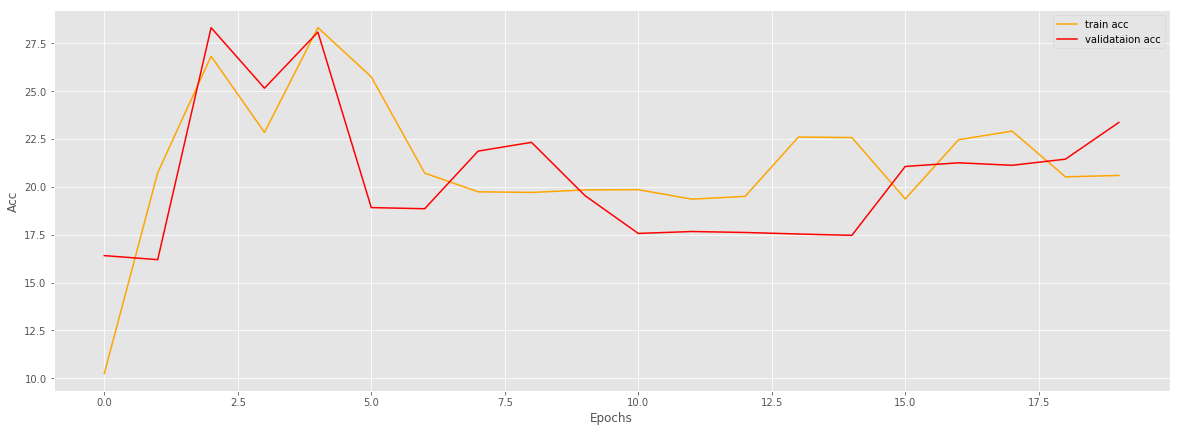

Max tr acc =  28.325
Max va acc =  28.32


In [19]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

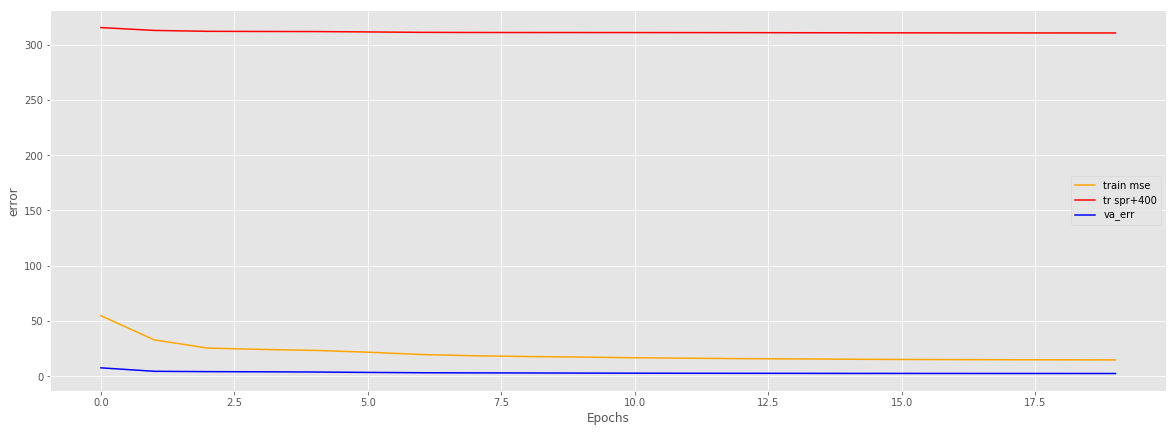

In [20]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 400+result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr+400')
plt.plot(va_err, color='blue', label='va_err')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()